## **Employee Attrition Prediction for RCC Strategy**
The objective is to build a model that predicts the probability of employee attrition after being offered a Rationalization Compensation Contract (RCC), using historical closure data.


## Exploratory Data Analysis

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import joblib

# Setup
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid") 
os.makedirs("eda_outputs", exist_ok=True)

# Load data
df = pd.read_csv("employee_attrition_previous_closure.csv")
df.head()

,Attrition,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,No,50.0,Travel_Rarely,1126.0,Research & Development,1.0,2,Medical,1,997,4,Male,66,3,4,Research Director,4,Divorced,17399,6615,9,Y,No,22,4,3,80,1,32,1,2,5,4,1,3
1,No,36.0,Travel_Rarely,216.0,Research & Development,6.0,2,Medical,1,178,2,Male,84,3,2,Manufacturing Director,2,Divorced,4941,2819,6,Y,No,20,4,4,80,2,7,0,3,3,2,0,1
2,Yes,21.0,Travel_Rarely,337.0,Sales,7.0,1,Marketing,1,1780,2,Male,31,3,1,Sales Representative,2,Single,2679,4567,1,Y,No,13,3,2,80,0,1,3,3,1,0,1,0
3,No,50.0,Travel_Frequently,1246.0,Human Resources,NaN,3,Medical,1,644,1,Male,99,3,5,Manager,2,Married,18200,7999,1,Y,No,11,3,3,80,1,32,2,3,32,5,10,7
4,No,52.0,Travel_Rarely,994.0,Research & Development,7.0,4,Life Sciences,1,1118,2,Male,87,3,3,Healthcare Representative,2,Single,10445,15322,7,Y,No,19,3,4,80,0,18,4,3,8,6,4,0


### Data Exploration and Visualisation 

In [47]:
print("Shape:", df.shape)
print("Data Types:\n", df.dtypes)

Shape: (1029, 35)
Data Types:
 Attrition                    object
Age                         float64
BusinessTravel               object
DailyRate                   float64
Department                   object
DistanceFromHome            float64
Education                     int64
EducationField               object
EmployeeCount                 int64
EmployeeNumber                int64
EnvironmentSatisfaction       int64
Gender                       object
HourlyRate                    int64
JobInvolvement                int64
JobLevel                      int64
JobRole                      object
JobSatisfaction               int64
MaritalStatus                object
MonthlyIncome                 int64
MonthlyRate                   int64
NumCompaniesWorked            int64
Over18                       object
OverTime                     object
PercentSalaryHike             int64
PerformanceRating             int64
RelationshipSatisfaction      int64
StandardHours                 int

#### Dataset Overview

- **Dataset Size:** 1,029 rows × 35 columns
- **Target Variable:** `Attrition` (Yes/No)
- **Feature Types:**
  - **Numerical:** Age, MonthlyIncome, DistanceFromHome, YearsAtCompany, etc.
  - **Categorical:** Department, Gender, JobRole, MaritalStatus, etc.
- **Data Types:** Mix of `int64`, `float64`, and `object`
 `EmployeeNumber` (unique), `Over18` (constant)


In [48]:
# Identifying missiing values
print("Missing Values:\n", df.isnull().sum())


Missing Values:
 Attrition                     0
Age                         136
BusinessTravel                5
DailyRate                    27
Department                    0
DistanceFromHome             95
Education                     0
EducationField                0
EmployeeCount                 0
EmployeeNumber                0
EnvironmentSatisfaction       0
Gender                        0
HourlyRate                    0
JobInvolvement                0
JobLevel                      0
JobRole                       0
JobSatisfaction               0
MaritalStatus                 5
MonthlyIncome                 0
MonthlyRate                   0
NumCompaniesWorked            0
Over18                        0
OverTime                      0
PercentSalaryHike             0
PerformanceRating             0
RelationshipSatisfaction      0
StandardHours                 0
StockOptionLevel              0
TotalWorkingYears             0
TrainingTimesLastYear         0
WorkLifeBalance        

#### Missing Values Summary

- Total Columns with Missing Data: 5
- **Top Missing Columns:**
  - `Age`: 136 missing
  - `DistanceFromHome`: 95 missing
  - `DailyRate`: 27 missing
  - `MaritalStatus`: 5 missing
  - `BusinessTravel`: 5 missing

In [49]:
df.describe(include='all')

,Attrition,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1029,893.000000,1024,1002.000000,1029,934.000000,1029.000000,1029,1029.0,1029.000000,1029.000000,1029,1029.000000,1029.000000,1029.000000,1029,1029.000000,1024,1029.000000,1029.000000,1029.000000,1029,1029,1029.000000,1029.000000,1029.000000,1029.0,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000
unique,2,NaN,3,NaN,3,NaN,NaN,6,NaN,NaN,NaN,2,NaN,NaN,NaN,9,NaN,3,NaN,NaN,NaN,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,No,NaN,Travel_Rarely,NaN,Research & Development,NaN,NaN,Life Sciences,NaN,NaN,NaN,Male,NaN,NaN,NaN,Sales Executive,NaN,Married,NaN,NaN,NaN,Y,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,853,NaN,723,NaN,676,NaN,NaN,426,NaN,NaN,NaN,617,NaN,NaN,NaN,217,NaN,474,NaN,NaN,NaN,1029,731,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,37.930571,NaN,800.528942,NaN,9.930407,2.892128,NaN,1.0,1024.367347,2.683188,NaN,66.680272,2.713314,2.043732,NaN,2.712342,NaN,6449.796890,14250.629738,2.653061,NaN,NaN,15.260447,3.159378,2.689990,80.0,0.822157,11.196307,2.782313,2.748299,6.942663,4.215743,2.119534,4.005831
std,NaN,9.395978,NaN,408.109828,NaN,8.421791,1.053541,NaN,0.0,606.301635,1.096829,NaN,20.474094,0.710146,1.118918,NaN,1.096889,NaN,4794.525367,7088.757938,2.508186,NaN,NaN,3.665779,0.366206,1.077767,0.0,0.874662,7.857581,1.283401,0.697278,6.068322,3.658595,3.108651,3.522574
min,NaN,18.000000,NaN,102.000000,NaN,1.000000,1.000000,NaN,1.0,1.000000,1.000000,NaN,30.000000,1.000000,1.000000,NaN,1.000000,NaN,1009.000000,2094.000000,0.000000,NaN,NaN,11.000000,3.000000,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,31.000000,NaN,458.250000,NaN,2.000000,2.000000,NaN,1.0,496.000000,2.000000,NaN,48.000000,2.000000,1.000000,NaN,2.000000,NaN,2814.000000,7950.000000,1.000000,NaN,NaN,12.000000,3.000000,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,NaN,37.000000,NaN,801.500000,NaN,8.000000,3.000000,NaN,1.0,1019.000000,3.000000,NaN,67.000000,3.000000,2.000000,NaN,3.000000,NaN,4735.000000,14295.000000,1.000000,NaN,NaN,14.000000,3.000000,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,NaN,44.000000,NaN,1162.000000,NaN,16.000000,4.000000,NaN,1.0,1553.000000,4.000000,NaN,84.000000,3.000000,3.000000,NaN,4.000000,NaN,8446.000000,20392.000000,4.000000,NaN,NaN,18.000000,3.000000,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,10.000000,7.000000,2.000000,7.000000


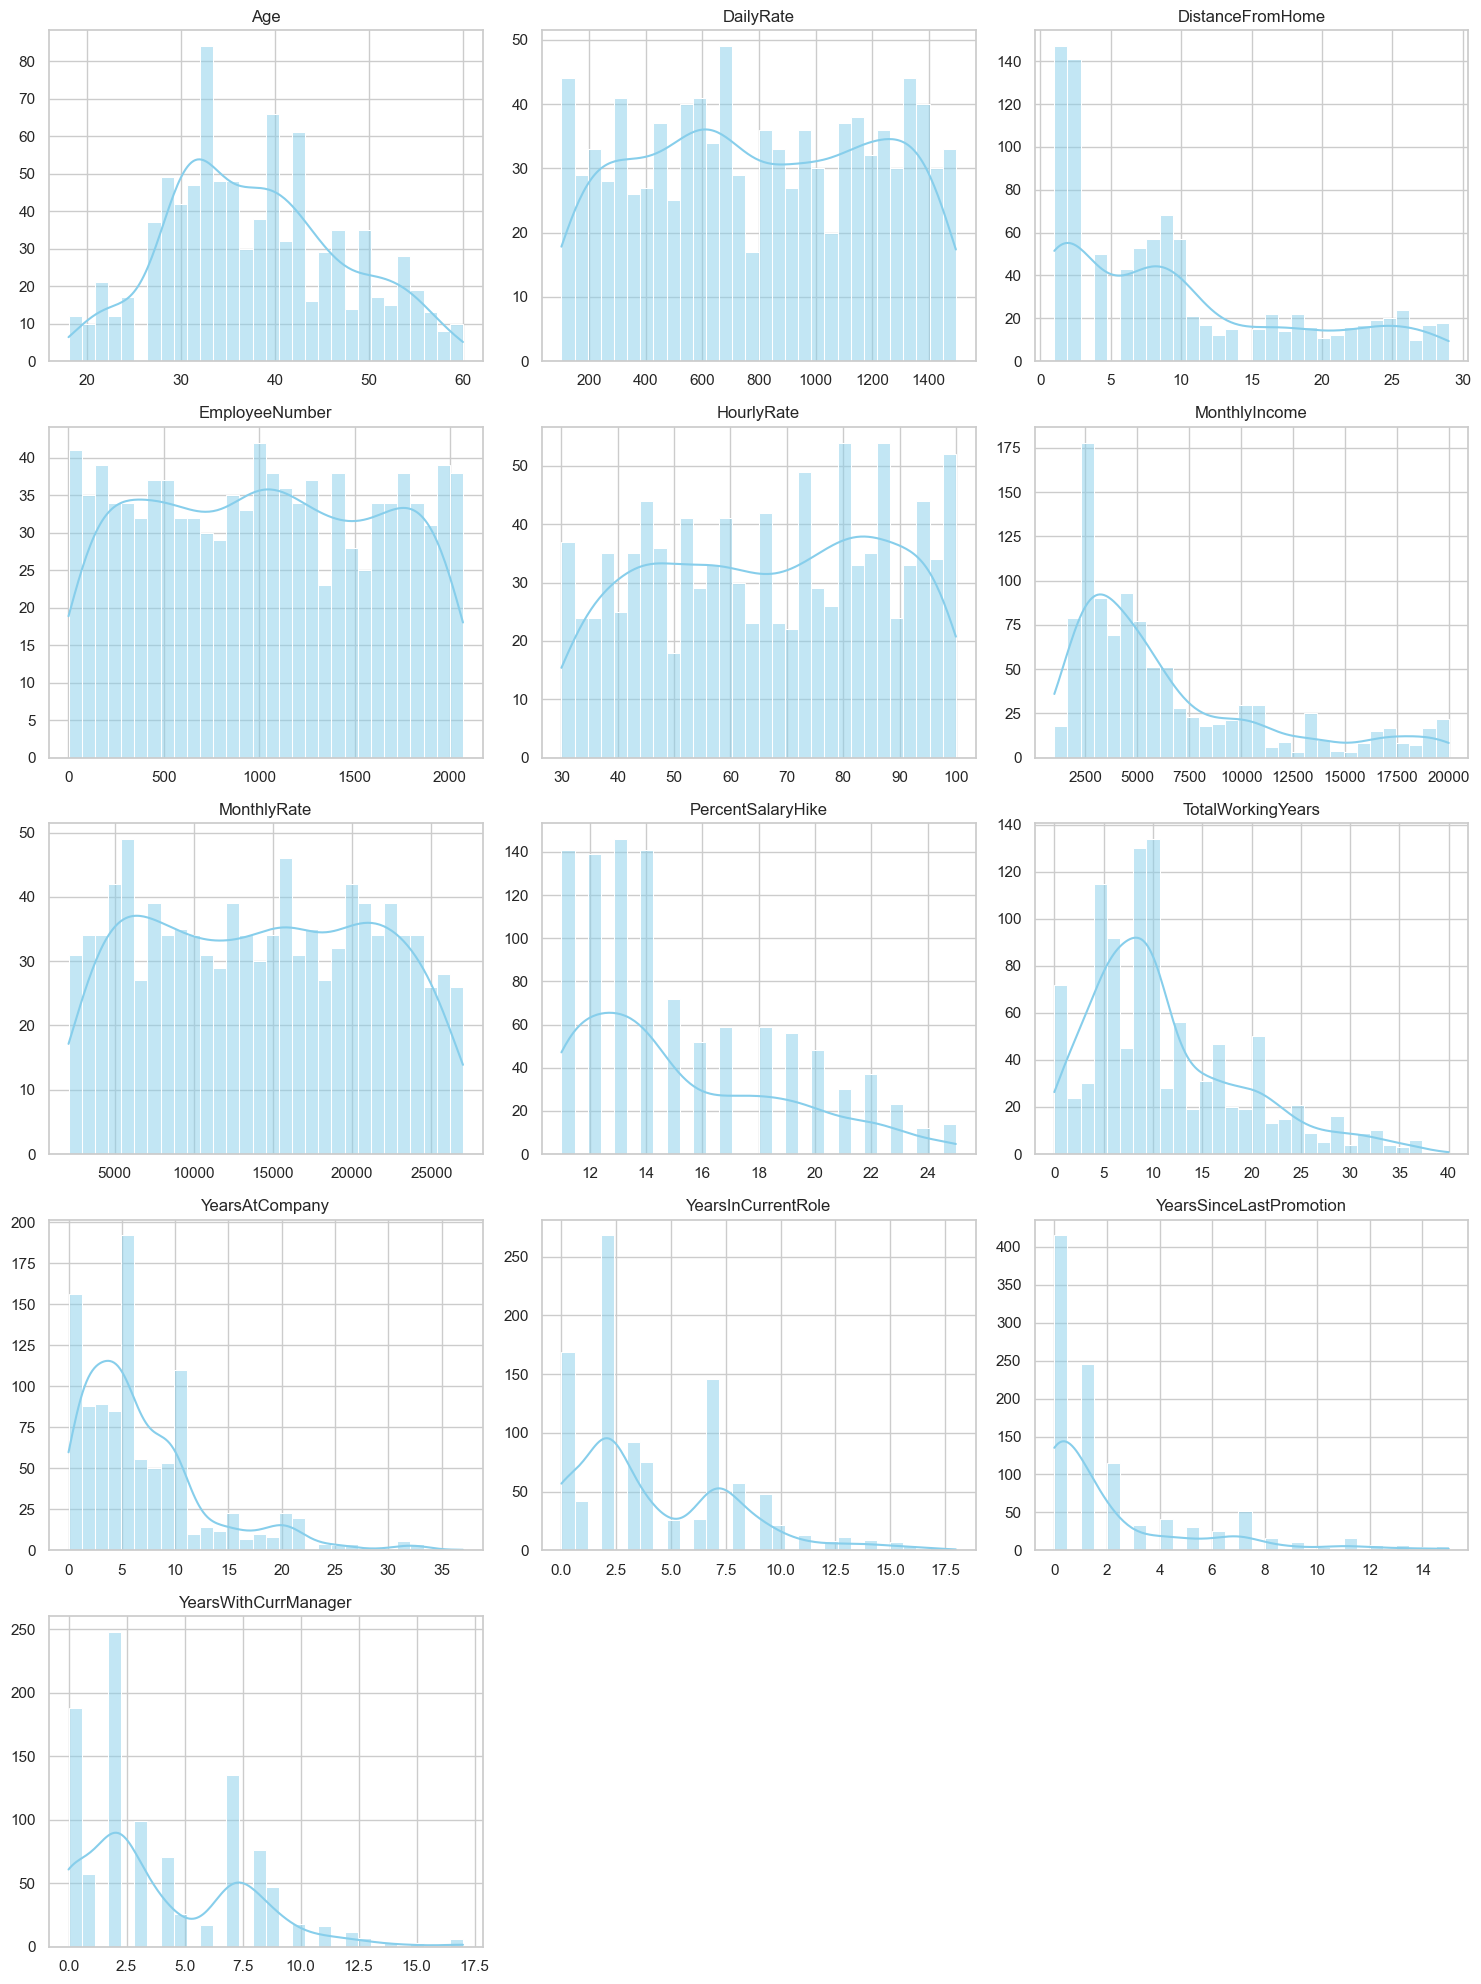

In [50]:
# List of columns to exclude
excluded_cols = [
    "Education", "EmployeeCount", "EnvironmentSatisfaction", "JobInvolvement", "JobLevel",
    "JobSatisfaction", "NumCompaniesWorked", "PerformanceRating", "RelationshipSatisfaction",
    "StandardHours", "StockOptionLevel", "TrainingTimesLastYear", "WorkLifeBalance"
]

# Filter numerical columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
filtered_num_cols = [col for col in num_cols if col not in excluded_cols]

# Setup subplot layout
n = len(filtered_num_cols)
cols = 3
rows = math.ceil(n / cols)

plt.figure(figsize=(cols * 5, rows * 4))

for idx, col in enumerate(filtered_num_cols, 1):
    plt.subplot(rows, cols, idx)
    sns.histplot(df[col], kde=True, bins=30, color='skyblue')
    plt.title(f"{col}")
    plt.xlabel("")
    plt.ylabel("")

plt.tight_layout()
plt.show()


#### Numerical Feature Distributions

- **Skewed Right (Positively Skewed):**
  - `MonthlyIncome`, `TotalWorkingYears`, `YearsAtCompany`, `YearsInCurrentRole`, `YearsWithCurrManager`, `YearsSinceLastPromotion`
  - Suggests most employees are early in their careers or tenure.

- **Roughly Uniform:**
  - `DailyRate`, `HourlyRate`, `MonthlyRate`, `EmployeeNumber`
  - May not contribute meaningfully to prediction.

- **Normal-like Distribution:**
  - `Age`: Slightly right-skewed, peaks around 35–40.

- **Others:**
  - `DistanceFromHome`: Right-skewed; most live close to work.
  - `PercentSalaryHike`: Concentrated between 11–15%.

Skewed features will be transformed before modelling.


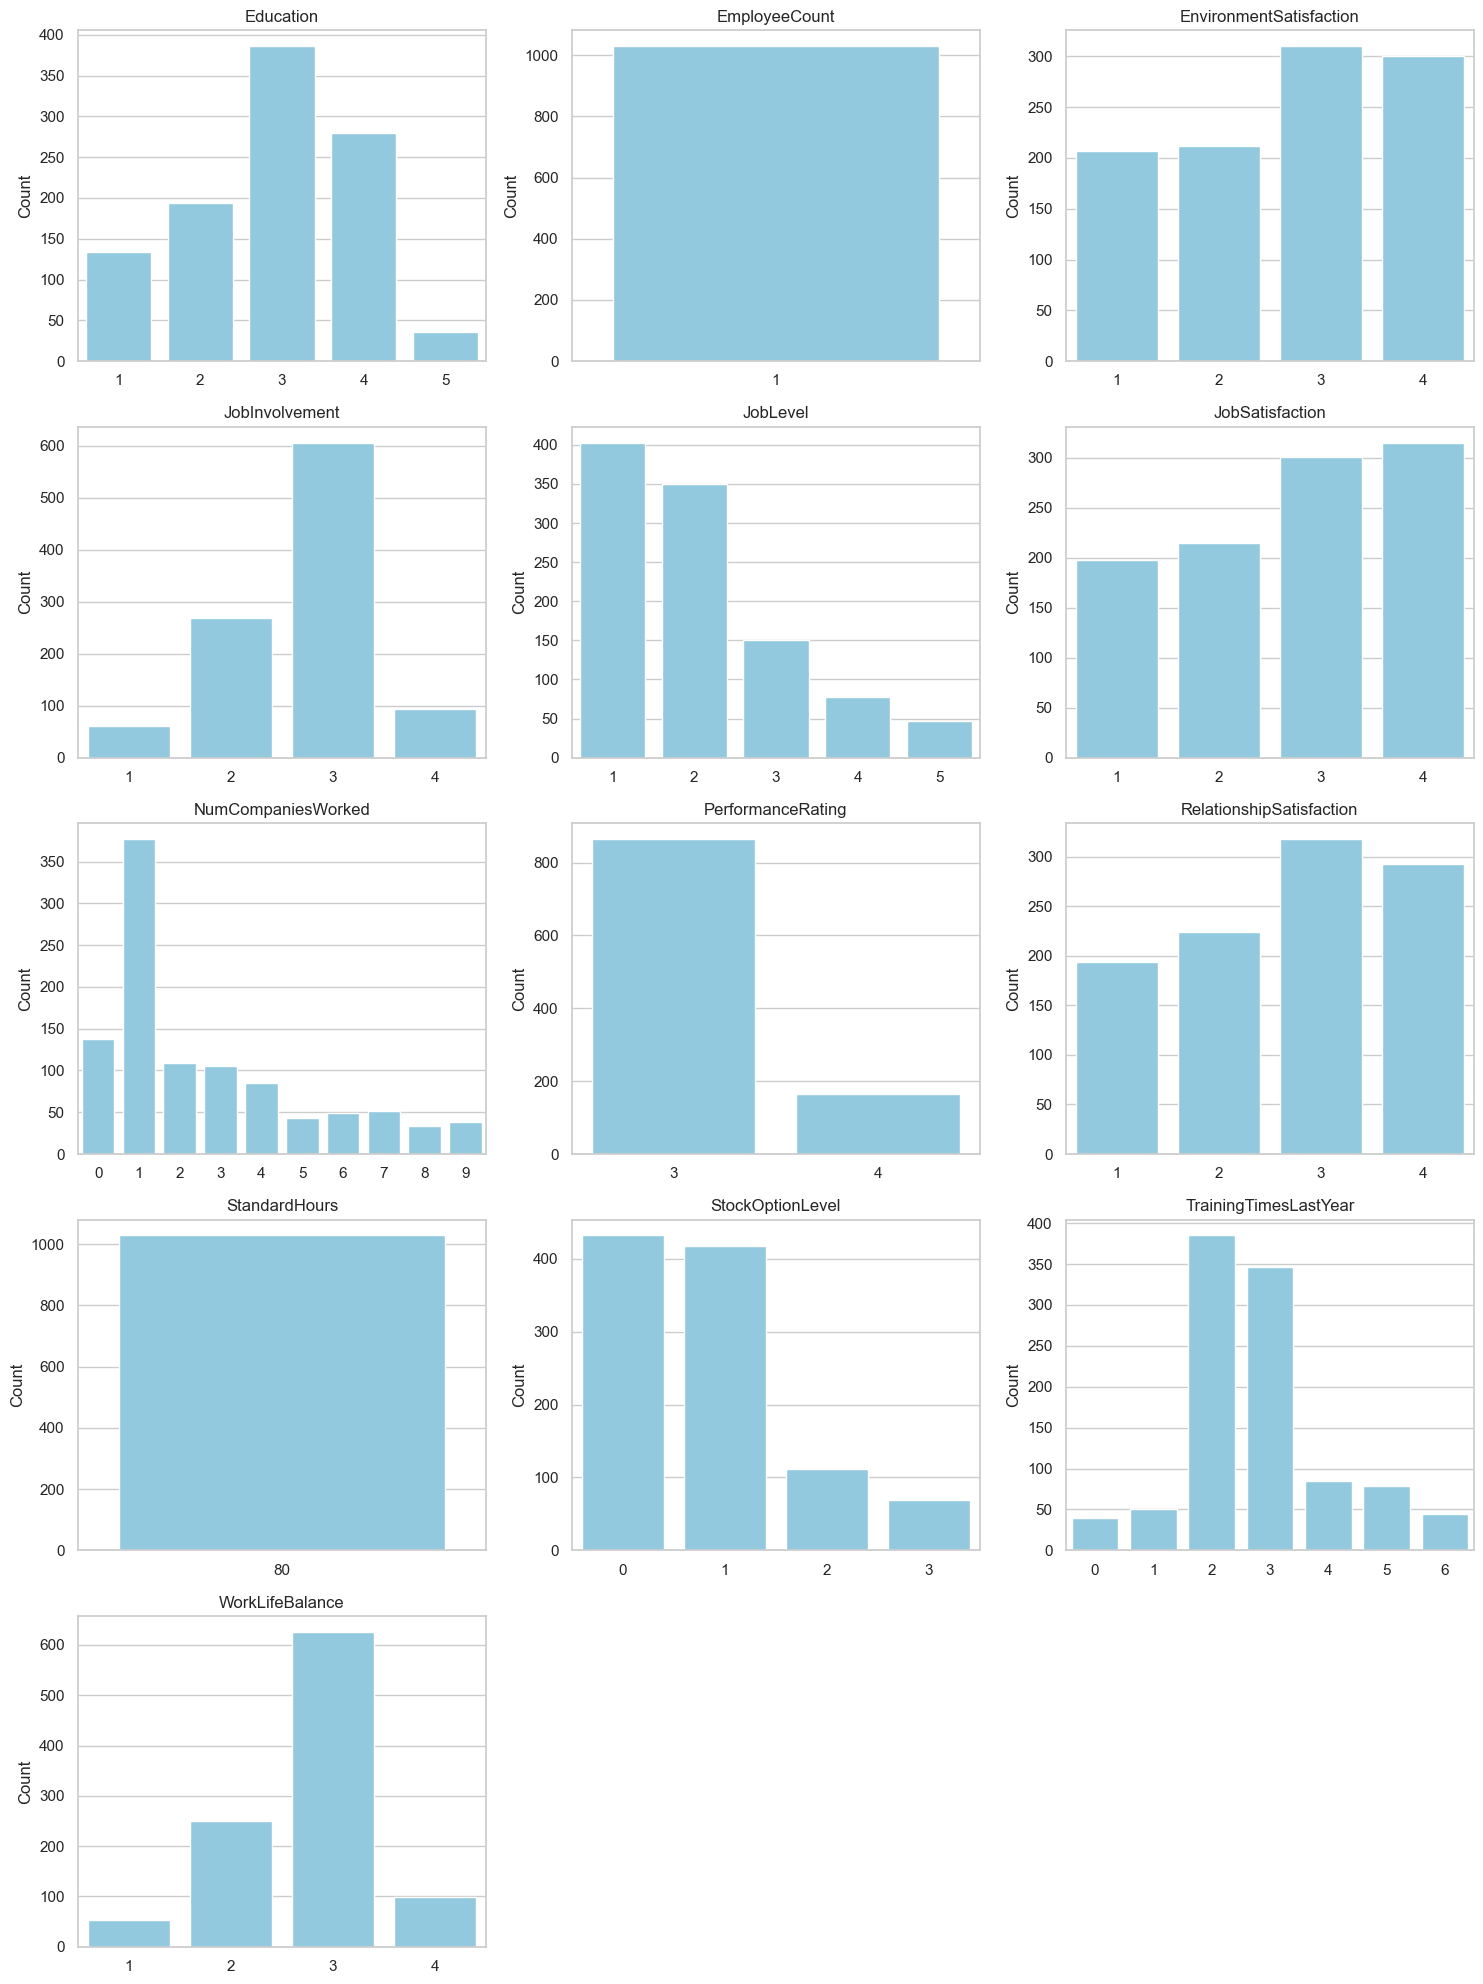

In [51]:
# Columns to be plotted (use exact dataset column names)
bar_cols = [
    "Education", "EmployeeCount", "EnvironmentSatisfaction", "JobInvolvement", "JobLevel",
    "JobSatisfaction", "NumCompaniesWorked", "PerformanceRating", "RelationshipSatisfaction",
    "StandardHours", "StockOptionLevel", "TrainingTimesLastYear", "WorkLifeBalance"
]

# Setup for subplots
n = len(bar_cols)
cols = 3
rows = math.ceil(n / cols)

plt.figure(figsize=(cols * 5, rows * 4))

for idx, col in enumerate(bar_cols, 1):
    plt.subplot(rows, cols, idx)
    val_counts = df[col].value_counts().sort_index()
    sns.barplot(x=val_counts.index.astype(str), y=val_counts.values, color="skyblue")  # single color to avoid palette warning
    plt.title(f"{col}")
    plt.xlabel("")
    plt.ylabel("Count")

plt.tight_layout()
plt.show()


#### Categorical & Ordinal Feature Distributions

- **Constant Features:**
  - `EmployeeCount`, `StandardHours` – single unique value → candidates for removal.

- **Skewed Categories:**
  - `PerformanceRating`: Majority rated 3 (standard).
  - `StockOptionLevel`: Mostly levels 0 and 1.
  - `TrainingTimesLastYear`: Concentrated between 2–3.
  - `NumCompaniesWorked`: Most have ≤ 3 prior companies.

- **Balanced/Useful Features:**
  - `Education`, `JobSatisfaction`, `RelationshipSatisfaction`, `WorkLifeBalance` show variability.
  - `JobLevel` and `JobInvolvement` skewed toward lower levels, reflecting junior-heavy workforce.


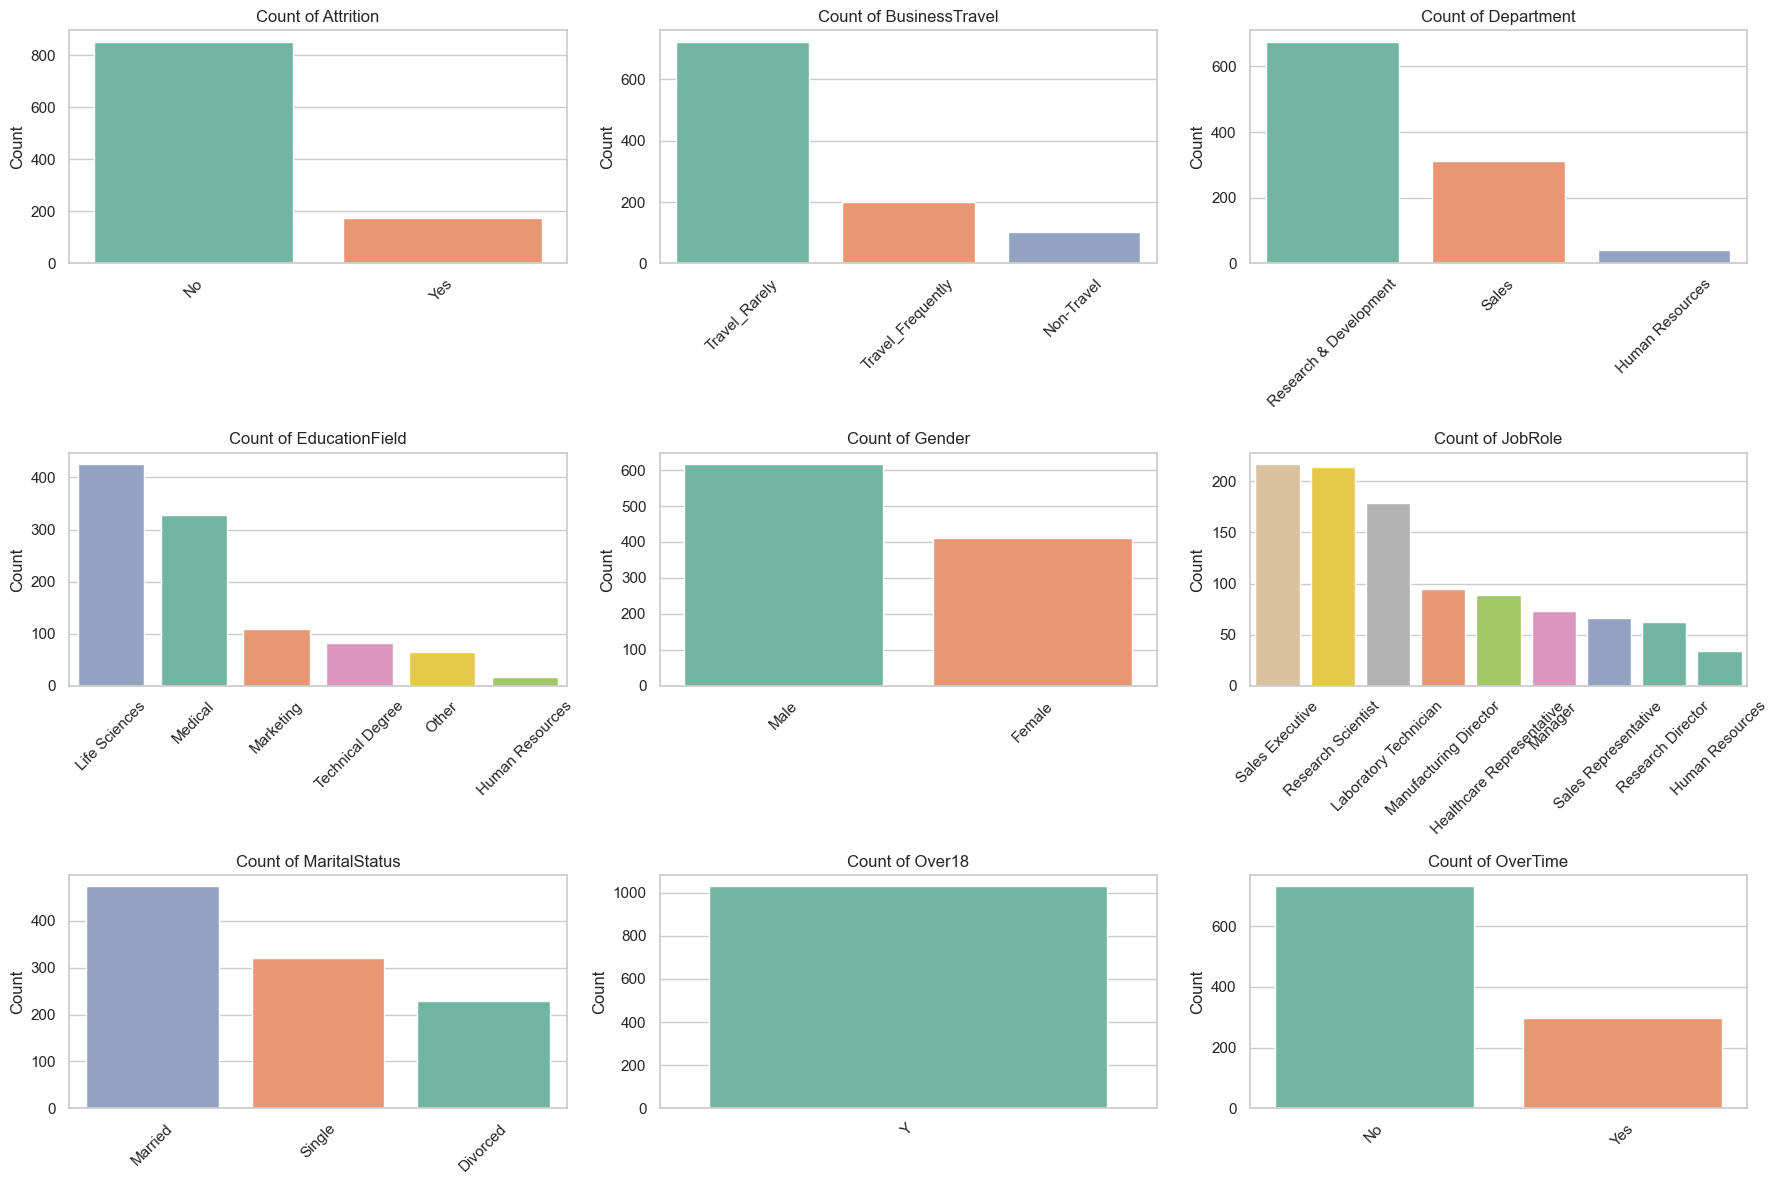

In [52]:
# Get all categorical columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Set up subplot grid
n = len(categorical_cols)
cols = 3
rows = math.ceil(n / cols)

plt.figure(figsize=(cols * 6, rows * 4))

for idx, col in enumerate(categorical_cols, 1):
    plt.subplot(rows, cols, idx)
    sns.countplot(data=df, x=col, hue=col, legend=False, order=df[col].value_counts().index, palette="Set2")
    plt.title(f"Count of {col}")
    plt.xticks(rotation=45)
    plt.xlabel("")
    plt.ylabel("Count")

plt.tight_layout()
plt.show()

#### Key Insights-Categorical Features

- **Department Distribution:** Majority in `Research & Development`, followed by `Sales`; `Human Resources` is underrepresented.

- **Business Travel:** Most travel rarely; frequent travelers are a small subset.

- **Gender:** Male employees outnumber female employees (~60:40 ratio).

- **Education Field:** Dominated by `Life Sciences` and `Medical`; others sparsely represented.

- **Job Role:** Concentrated in `Sales Executive`, `Research Scientist`, `Lab Technician`.

- **Marital Status:** Most employees are `Married`, followed by `Single` and `Divorced`.

- **Over18:** Single constant value (`Y`) → drop.

- **OverTime:** Majority do not work overtime.


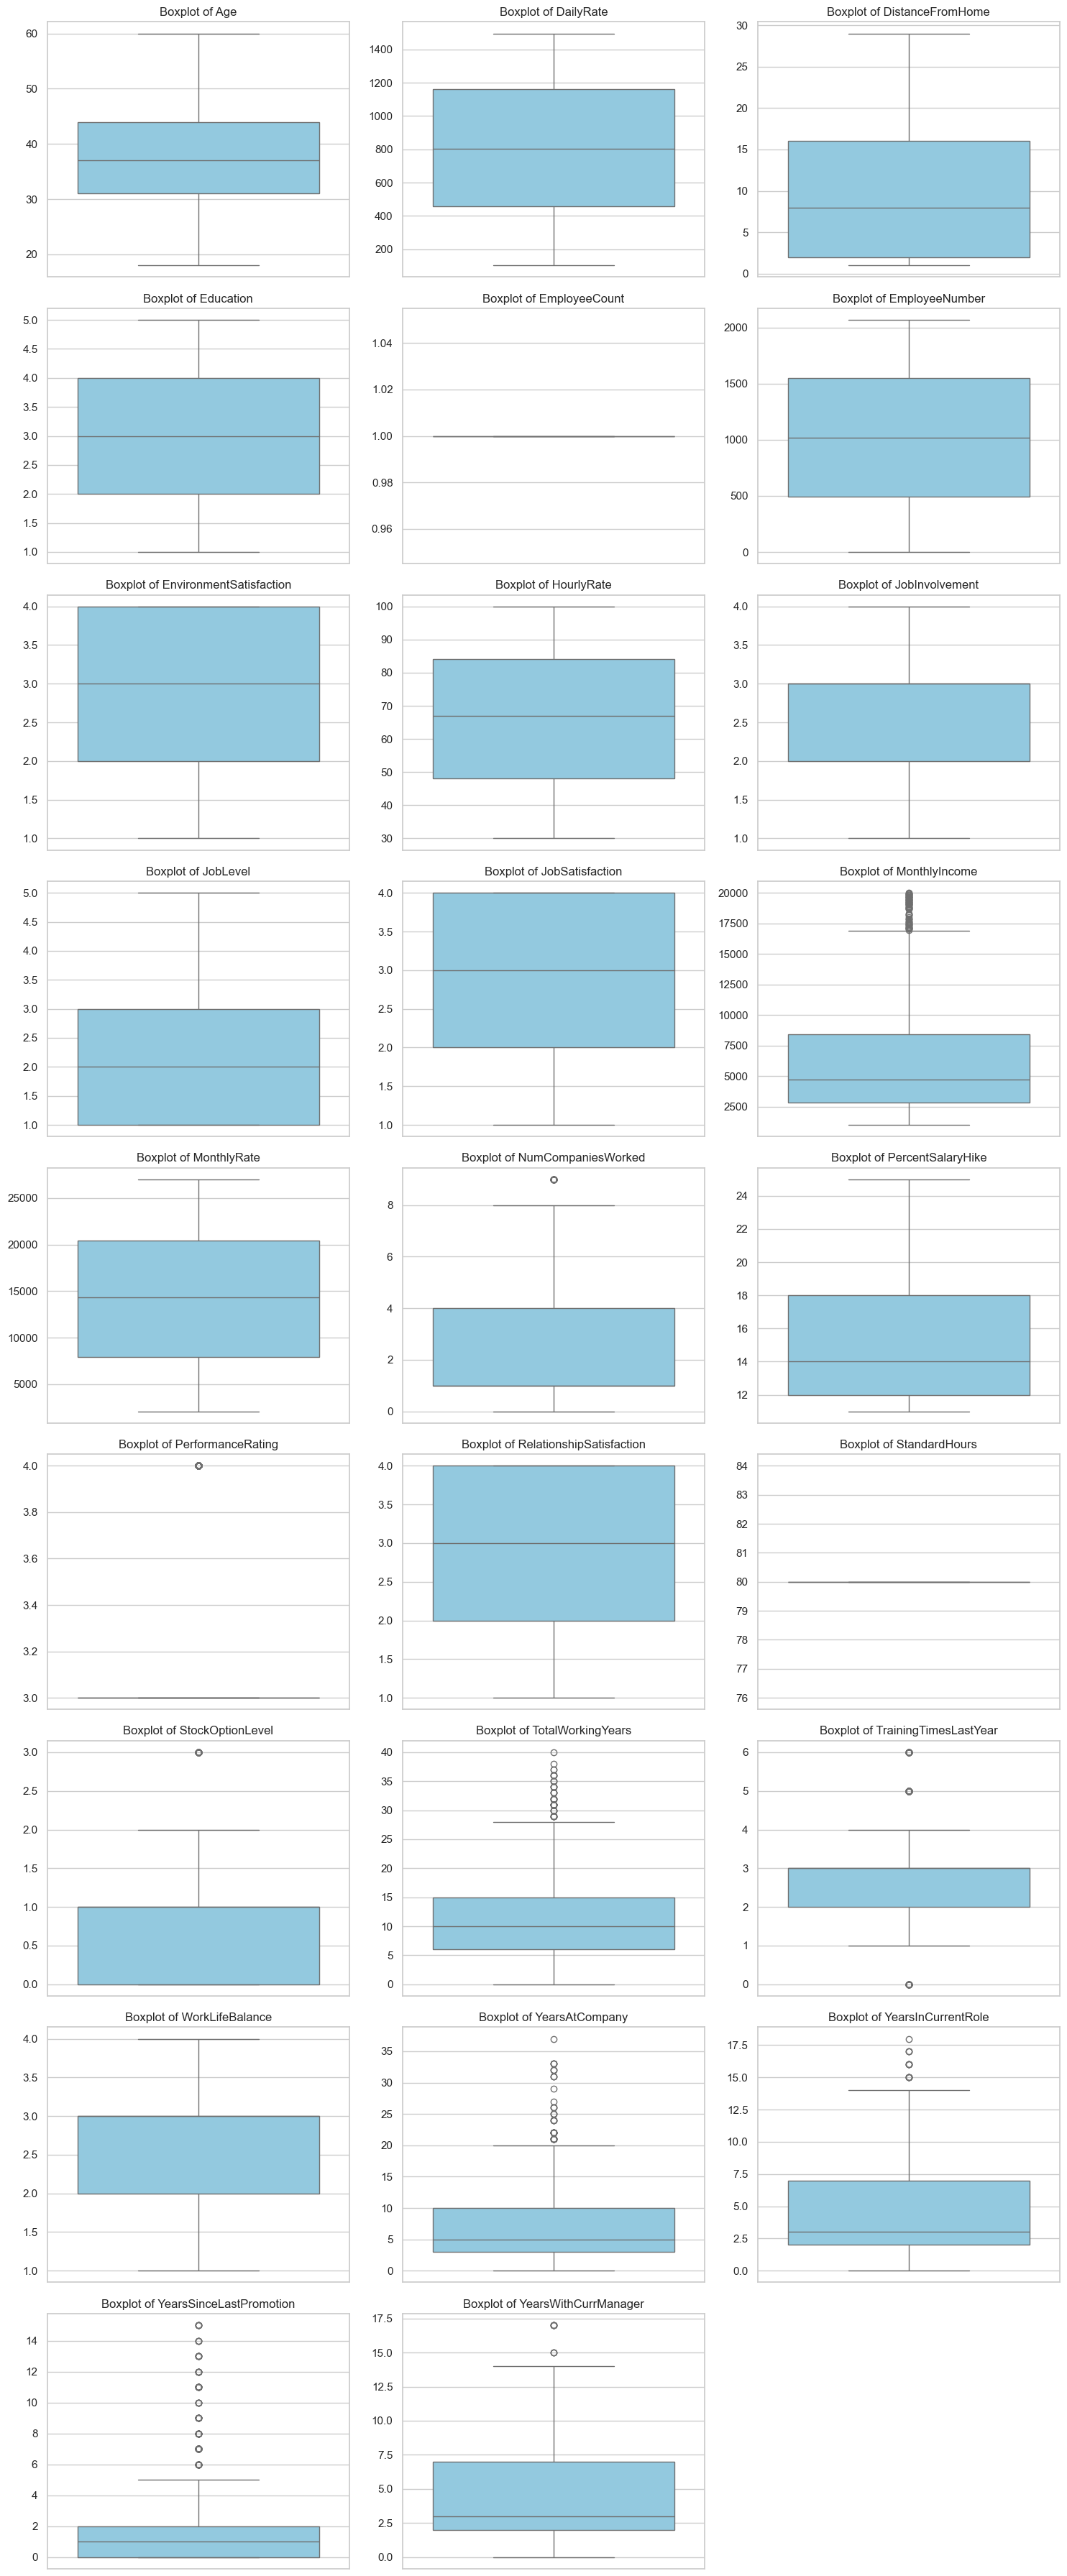

In [53]:
# Select only numerical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).drop(columns=['Attrition'], errors='ignore').columns.tolist()

# Setup subplot grid
n = len(numerical_cols)
cols = 3
rows = math.ceil(n / cols)

plt.figure(figsize=(cols * 5, rows * 4))

for idx, col in enumerate(numerical_cols, 1):
    plt.subplot(rows, cols, idx)
    sns.boxplot(y=df[col], color='skyblue')
    plt.title(f'Boxplot of {col}')
    plt.xlabel("")
    plt.ylabel("")

plt.tight_layout()
plt.savefig("eda_outputs/numerical_boxplots.png")
plt.show()

#### Outlier Detection

- **No Variation (Constant):**
  - `EmployeeCount`, `StandardHours` → drop.

- **Mild Outliers:**
  - `MonthlyIncome`, `TotalWorkingYears`, `YearsAtCompany`, `YearsInCurrentRole`, `YearsWithCurrManager`, `YearsSinceLastPromotion`
  - Values mostly within range; a few high-end outliers exist.

- **Clear Outliers:**
  - `NumCompaniesWorked`, `PerformanceRating` (single high point), `TrainingTimesLastYear` → sparse extreme values.

- **Symmetric Distributions:**
  - `Age`, `Education`, `JobSatisfaction`, `JobLevel`, `PercentSalaryHike`, `HourlyRate` → centered and balanced.



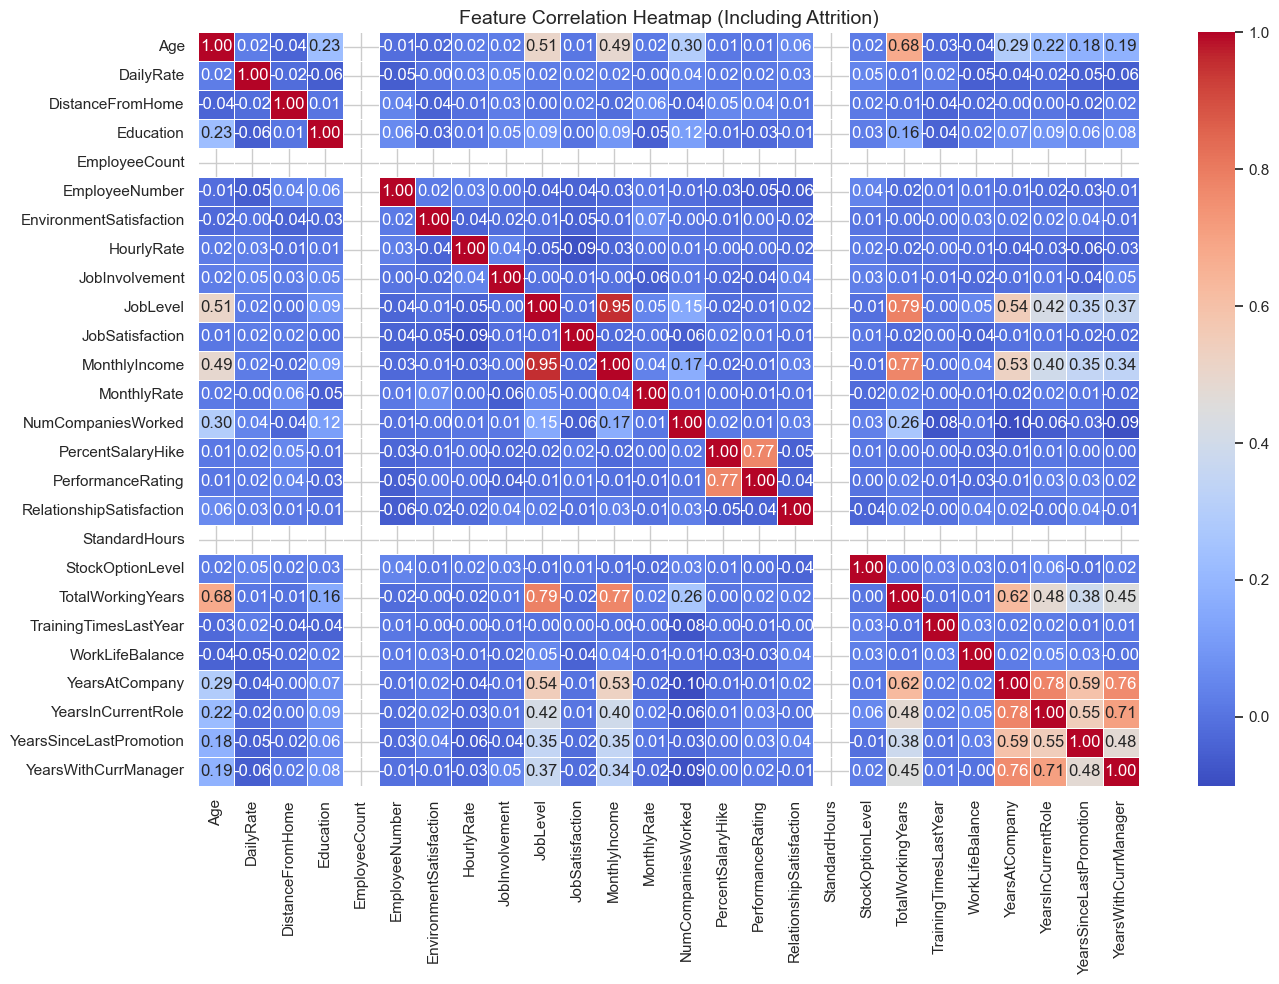

In [54]:
# Compute correlation matrix for numerical features (including Attrition)
corr_matrix = df.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap (Including Attrition)", fontsize=14)
plt.tight_layout()
plt.show()


#### Correlation Analysis

- **Strong Positive Correlations:**
  - `TotalWorkingYears` & `Age` (0.68)
  - `MonthlyIncome` & `JobLevel` (0.77)
  - `YearsAtCompany` & `YearsWithCurrManager` (0.76)
  - `YearsInCurrentRole` & `YearsWithCurrManager` (0.71)

- **Weak or No Correlation:**
  - Most features show low pairwise correlation (r < 0.3)
  - `Attrition` is not strongly linearly correlated with any single numeric variable

- **Redundant Pairs to Watch:**
  - High multicollinearity between tenure-related features: `YearsAtCompany`, `YearsInCurrentRole`, `YearsWithCurrManager`, `TotalWorkingYears`



Attrition Class Distribution (%):
Attrition
No     82.896016
Yes    17.103984
Name: proportion, dtype: float64


C:\Users\PURVI\AppData\Local\Temp\ipykernel_4512\347656554.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_dist.index, y=class_dist.values * 100, palette="Set2")


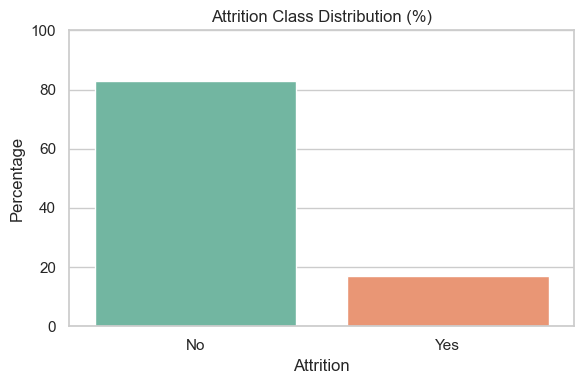

In [55]:
# Check class distribution of the target variable
y=df['Attrition']
class_dist = y.value_counts(normalize=True)

print("Attrition Class Distribution (%):")
print(class_dist * 100)

# Visual pie chart or barplot (optional)
plt.figure(figsize=(6,4))
sns.barplot(x=class_dist.index, y=class_dist.values * 100, palette="Set2")
plt.title("Attrition Class Distribution (%)")
plt.ylabel("Percentage")
plt.xlabel("Attrition")
plt.xticks([0, 1], ['No', 'Yes'])
plt.ylim(0, 100)
plt.tight_layout()
plt.show()


#### Class Imbalance

- **Attrition Distribution:**
  - `No`: 82.9%
  - `Yes`: 17.1%

The dataset is highly imbalanced toward non-attrition cases.

Class weights technique will be applied to ensure balanced model learning.


### Preprocessing for Modelling

#### Missing Value Imputation

- **Numerical Features:** Imputed using median values.
- **Categorical Features:** Imputed using most frequent (mode) values.
- **Result:** No missing values remain after imputation.


In [56]:
num_impute_dict = {col: df[col].median() for col in df.select_dtypes(include=['int64', 'float64']).columns}
df.fillna(value=num_impute_dict, inplace=True)

cat_impute_dict = {col: df[col].mode()[0] for col in df.select_dtypes(include=['object']).columns}
df.fillna(value=cat_impute_dict, inplace=True)

# Show remaining missing
missing = df.isnull().sum()
print("Check for missing values- ", missing[missing > 0])

Check for missing values-  Series([], dtype: int64)


#### Feature Reduction

Dropped non-informative or constant columns:
- `EmployeeCount`, `StandardHours`, `Over18`: Constant values
- `EmployeeNumber`: Unique identifier with no predictive value


In [57]:
# Drop non-informative columns
df.drop(columns=["EmployeeCount", "StandardHours", "Over18","EmployeeNumber"], inplace=True)

#### Target Encoding

Mapped `Attrition` to binary format:
- `Yes` → 1 (Employee Left)
- `No` → 0 (Employee Stayed)


In [58]:
# Map target variable to binary
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})

#### Log Transformer

Defined a reusable `LogTransformer` to apply `log1p` transformation on skewed numerical features.  
- Handles both NumPy arrays and DataFrames.
- Helps normalize distributions and reduce the impact of extreme values.


In [59]:
# Custom Log Transformer
from sklearn.base import BaseEstimator, TransformerMixin

class LogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self.cols = cols

    def fit(self, X, y=None):
        self.cols_ = [i for i in range(X.shape[1])] if isinstance(X, np.ndarray) else self.cols
        return self

    def transform(self, X):
        if isinstance(X, np.ndarray):
            X = X.copy()
            for i in self.cols_:
                X[:, i] = np.log1p(X[:, i])
            return X
        else:
            X = X.copy()
            for col in self.cols:
                if col in X.columns:
                    X[col] = np.log1p(X[col])
            return X
    def get_feature_names_out(self, input_features=None):
        return np.array(input_features)

In [60]:
target = 'Attrition'

# Manually defined feature sets based on EDA
categorical_cols = [
    "BusinessTravel", "Department", "EducationField", "Gender",
    "JobRole", "MaritalStatus", "OverTime"
]

numerical_cols = [
    "Age", "DailyRate", "DistanceFromHome", "Education", "EnvironmentSatisfaction",
    "HourlyRate", "JobInvolvement", "JobLevel", "JobSatisfaction", "MonthlyIncome",
    "MonthlyRate", "NumCompaniesWorked", "PercentSalaryHike", "PerformanceRating",
    "RelationshipSatisfaction", "StockOptionLevel", "TotalWorkingYears", "TrainingTimesLastYear",
    "WorkLifeBalance", "YearsAtCompany", "YearsInCurrentRole", "YearsSinceLastPromotion",
    "YearsWithCurrManager"
]

log_cols = ["MonthlyIncome", "TotalWorkingYears", "YearsAtCompany"]
winsor_cols = ["YearsAtCompany", "YearsSinceLastPromotion", "YearsInCurrentRole", "YearsWithCurrManager"]

#### Numerical Pipeline

- **Imputation:** Median strategy for missing values
- **Transformation:** `LogTransformer` to normalize skewed features
- **Scaling:** `RobustScaler` to reduce the influence of outliers


In [61]:
from sklearn.preprocessing import RobustScaler

numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('log', LogTransformer(cols=log_cols)),  # still useful for skewed features
    ('scaler', RobustScaler())
])


#### Categorical Pipeline

- **Imputation:** Most frequent value (mode) for missing entries  
- **Encoding:** One-hot encoding with first category dropped to avoid multicollinearity


In [62]:
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

#### Column Transformer

Combined numerical and categorical pipelines using `ColumnTransformer`:
- Applies numerical pipeline to `numerical_cols`
- Applies categorical pipeline to `categorical_cols`


In [63]:
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

### Task 1: Predicting RCC Acceptance Probability for previous closure

#### Train/Test Split & Transformation

- **Features (`X`)** and **Target (`y`)** separated (`Attrition`)
- **Split:** 80% training, 20% testing with stratification to preserve class balance
- **Transformation:** Applied full preprocessing pipeline to both sets


In [64]:
# Define Features and Target
target = 'Attrition'
X = df.drop(columns=[target])
y = df[target]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [65]:
# Get feature names after preprocessing
feature_names = preprocessor.get_feature_names_out()

# Convert transformed data back to DataFrame (for inspection only)
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=feature_names)
X_train_transformed_df.head()

,num__Age,num__DailyRate,num__DistanceFromHome,num__Education,num__EnvironmentSatisfaction,num__HourlyRate,num__JobInvolvement,num__JobLevel,num__JobSatisfaction,num__MonthlyIncome,num__MonthlyRate,num__NumCompaniesWorked,num__PercentSalaryHike,num__PerformanceRating,num__RelationshipSatisfaction,num__StockOptionLevel,num__TotalWorkingYears,num__TrainingTimesLastYear,num__WorkLifeBalance,num__YearsAtCompany,num__YearsInCurrentRole,num__YearsSinceLastPromotion,num__YearsWithCurrManager,cat__BusinessTravel_Travel_Frequently,cat__BusinessTravel_Travel_Rarely,cat__Department_Research & Development,cat__Department_Sales,cat__EducationField_Life Sciences,cat__EducationField_Marketing,cat__EducationField_Medical,cat__EducationField_Other,cat__EducationField_Technical Degree,cat__Gender_Male,cat__JobRole_Human Resources,cat__JobRole_Laboratory Technician,cat__JobRole_Manager,cat__JobRole_Manufacturing Director,cat__JobRole_Research Director,cat__JobRole_Research Scientist,cat__JobRole_Sales Executive,cat__JobRole_Sales Representative,cat__MaritalStatus_Married,cat__MaritalStatus_Single,cat__OverTime_Yes
0,-0.597362,-1.313011,-0.150130,0.436829,-0.563171,0.247300,-2.409421,0.000000,0.000000,0.230965,0.393964,0.557493,0.622912,0.000000,-0.563171,-1.0,0.188272,0.000000,-1.00000,0.284383,0.706695,1.261860,0.706695,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
1,0.347896,0.594707,0.219671,0.000000,-0.563171,-0.520277,0.000000,1.000000,0.000000,1.238762,0.134353,-0.442507,-0.377088,0.000000,0.436829,-1.0,0.879247,-4.818842,0.00000,1.328325,1.413390,1.892789,0.826780,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.429689,-0.460697,0.719229,-0.563171,-1.356915,0.582918,0.000000,0.000000,0.000000,-0.034427,-0.112549,0.000000,-0.588010,0.000000,-0.563171,0.0,0.673769,0.000000,0.00000,0.000000,0.227505,-0.630930,-0.293305,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,-0.092700,0.587237,0.062940,0.436829,-1.356915,0.000000,0.775660,-0.584963,-0.563171,-0.456860,-0.473276,-0.442507,1.126365,0.223144,-0.563171,-1.0,-0.683121,0.000000,0.00000,0.000000,0.227505,-0.630930,-0.293305,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.597362,-0.088245,-0.656289,0.436829,-0.563171,0.077868,0.000000,-0.584963,0.000000,-0.270690,0.248180,-0.442507,0.000000,0.000000,0.436829,0.0,-0.509392,-1.000000,0.77566,0.000000,-0.293305,-0.630930,0.000000,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


#### Model Setup & Hyperparameter Grids

- **Models:** Logistic Regression, Decision Tree, Random Forest, SVM  
- **Class Weighting:** Set to `'balanced'` to address class imbalance  
- **Hyperparameter Grids:** Defined for each model to enable grid search tuning  
  - Logistic Regression: `C`, `penalty`, `solver`  
  - Decision Tree & Random Forest: `max_depth`, `min_samples_split`, `n_estimators`  
  - SVM: `C`, `kernel`


In [66]:
# Model & Hyperparameter Grids
models = {
    'LogisticRegression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    'DecisionTree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
    'RandomForest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'SVM': SVC(class_weight='balanced', probability=True, random_state=42)
}
param_grids = {
    'LogisticRegression': {
        'C': [0.01, 0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    },
    'DecisionTree': {
        'max_depth': [3, 5, 10, None],
        'min_samples_split': [2, 5, 10]
    },
    'RandomForest': {
        'n_estimators': [50, 100],
        'max_depth': [5, 10, None],
        'min_samples_split': [2, 5]
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    }
}

#### Model Evaluation
**Metrics Used for Evaluation:** Accuracy, ROC-AUC, Recall, Precision  

In [67]:
# Model Evaluation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

for name, model in models.items():
    grid = GridSearchCV(model, param_grids[name], cv=cv, scoring='roc_auc', n_jobs=-1)
    grid.fit(X_train_transformed, y_train)
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test_transformed)
    y_proba = best_model.predict_proba(X_test_transformed)[:, 1]
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_proba),
        "Recall": recall_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred)
    })

# Display Final Comparison Table
results_df = pd.DataFrame(results)
print("\n Final Model Comparison:\n")
print(results_df.sort_values(by="ROC-AUC", ascending=False).to_string(index=False))


 Final Model Comparison:

             Model  Accuracy  ROC-AUC   Recall  Precision
LogisticRegression  0.796117 0.877026 0.800000   0.444444
               SVM  0.810680 0.875689 0.828571   0.467742
      RandomForest  0.854369 0.816207 0.171429   0.857143
      DecisionTree  0.762136 0.598329 0.457143   0.347826


#### Final Model Selection: Support Vector Machine (SVM)

- **Best Recall (0.829)** and strong ROC-AUC (0.876), making it ideal for identifying likely leavers.
- High recall minimizes the risk of missing at-risk employees, which is crucial for effective RCC allocation and cost-saving.
- **Balanced Performance:** SVM offers a solid trade-off across all metrics, ensuring robust and generalizable predictions in an imbalanced HR dataset.


#### Implementation of selected model for final evaluation


In [68]:
# SVM Classifier with Hyperparameter Tuning
print("Tuning SVM...")
svm = SVC(class_weight='balanced', probability=True, random_state=42)
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'linear'],
    'gamma': ['scale', 'auto']
}
svm_grid = GridSearchCV(svm, svm_param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
svm_grid.fit(X_train_transformed, y_train)

best_svm = svm_grid.best_estimator_
print("Best Params (SVM):", svm_grid.best_params_)

Tuning SVM...
Best Params (SVM): {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}


In [69]:
# Evaluate Tuned SVM
print("\n SVM Evaluation:")
y_pred_svm = best_svm.predict(X_test_transformed)
y_proba_svm = best_svm.predict_proba(X_test_transformed)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred_svm))
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_svm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))


 SVM Evaluation:
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.81      0.88       171
           1       0.47      0.83      0.60        35

    accuracy                           0.81       206
   macro avg       0.71      0.82      0.74       206
weighted avg       0.87      0.81      0.83       206

Accuracy: 0.8106796116504854
ROC-AUC: 0.8756892230576442
Confusion Matrix:
 [[138  33]
 [  6  29]]


#### SVM Evaluation Results

- **Accuracy:** 81.1%
- **ROC-AUC:** 0.876
- **Recall (Class 1 - Leavers):** 83% → most leavers correctly identified
- **Precision (Class 1):** 47% → moderate false positive rate
- **F1-Score (Class 1):** 0.60 → balanced view of precision and recall
- **Confusion Matrix:** 
- **True Positives (29):** Leavers correctly identified  
- **False Negatives (6):** Leavers incorrectly predicted to stay  
- **False Positives (33):** Non-leavers wrongly predicted as leavers  
- **True Negatives (138):** Non-leavers correctly identified

**Insight:** The model is highly effective at capturing actual leavers (low false negatives), aligning well with the business goal of proactive RCC targeting.


#### Evaluating ROC-AUC Curve

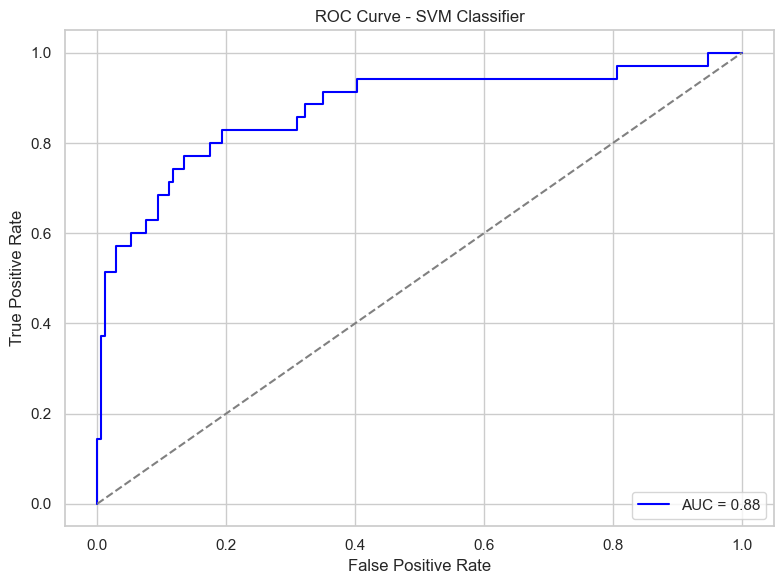

In [70]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test.to_numpy(), y_proba_svm)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba_svm):.2f}", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - SVM Classifier")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

#### ROC Curve – SVM Classifier

- **AUC = 0.88**, indicating excellent discriminatory power between leavers and non-leavers.
- The curve stays well above the diagonal baseline, confirming strong model performance across various thresholds.
- **True Positive Rate remains high** even at low False Positive Rates, supporting confident identification of at-risk employees.

The high AUC validates the SVM model’s suitability for reliable attrition prediction.


Top 15 Important Features:
                                   Feature  Coefficient
33            cat__JobRole_Human Resources     3.191173
13                  num__PerformanceRating    -3.104644
40       cat__JobRole_Sales Representative     2.244542
34      cat__JobRole_Laboratory Technician     1.607188
31    cat__EducationField_Technical Degree     1.513402
43                       cat__OverTime_Yes     1.486588
25  cat__Department_Research & Development     1.446230
23   cat__BusinessTravel_Travel_Frequently     1.421778
26                   cat__Department_Sales     1.396321
39            cat__JobRole_Sales Executive     1.228883
42               cat__MaritalStatus_Single     1.217556
38         cat__JobRole_Research Scientist     1.015889
36     cat__JobRole_Manufacturing Director     0.997027
35                    cat__JobRole_Manager     0.934804
24       cat__BusinessTravel_Travel_Rarely     0.916207


C:\Users\PURVI\AppData\Local\Temp\ipykernel_4512\3297639679.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, x='Coefficient', y='Feature', palette='viridis')
C:\Users\PURVI\AppData\Local\Temp\ipykernel_4512\3297639679.py:26: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout()
C:\Users\PURVI\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


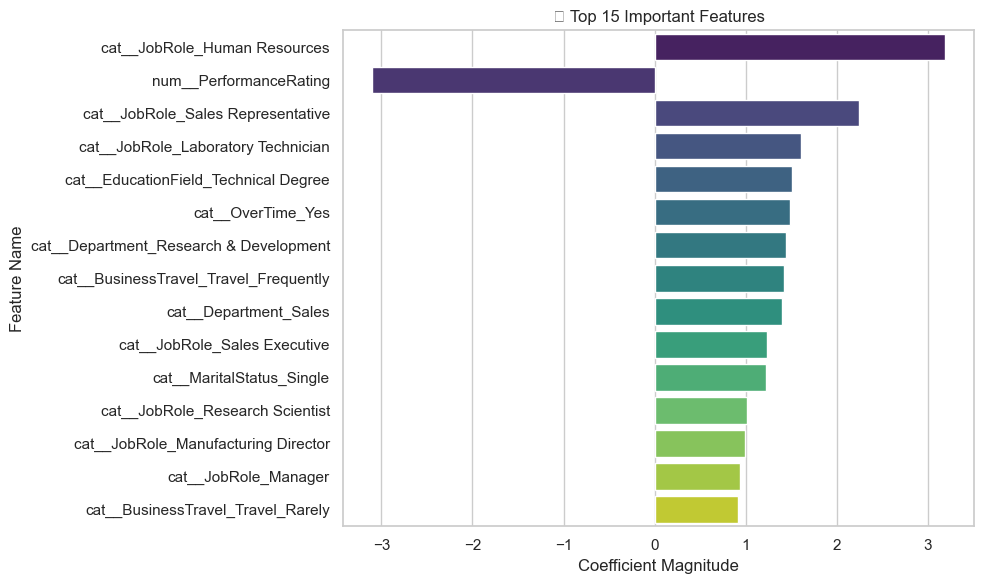

In [71]:
# Get feature names after transformation
feature_names = preprocessor.get_feature_names_out()

# Confirm kernel is linear
if best_svm.kernel == 'linear':
    # Extract and flatten coefficients
    coef = best_svm.coef_.flatten() 

feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coef
}).sort_values(by='Coefficient', key=abs, ascending=False)

print("Top 15 Important Features:")
print(feature_importance.head(15))

# Visualize Top 15 Important Features
top_n = 15
top_features = feature_importance.head(top_n).copy()

plt.figure(figsize=(10, 6))
sns.barplot(data=top_features, x='Coefficient', y='Feature', palette='viridis')
plt.title(f"🔍 Top {top_n} Important Features")
plt.xlabel("Coefficient Magnitude")
plt.ylabel("Feature Name")
plt.tight_layout()
plt.grid(True, axis='x')
plt.show()

#### Key Predictors of Attrition (RCC Acceptance)

The top 15 features (based on absolute SVM coefficients) highlight which employee attributes most influence the likelihood of accepting an RCC offer:

##### Positive Coefficients → Higher Likelihood of Leaving:
- **Job Roles:** `Human Resources`, `Sales Representative`, `Laboratory Technician`  
  → Employees in operational/support roles show greater propensity to leave.
- **Working Conditions:** `OverTime_Yes`, `BusinessTravel_Travel_Frequently`  
  → Suggests workload and travel frequency contribute to dissatisfaction.
- **Education & Department:** `Technical Degree`, `R&D`, `Sales`  
  → Mid-skill technical staff and non-management functions are more open to RCCs.
- **Demographics:** `MaritalStatus_Single`  
  → Possibly reflects lower relocation or financial constraints, enabling mobility.

##### Only Negative Coefficient:
- **PerformanceRating**  
  → High performers are significantly less likely to leave, possibly due to greater job satisfaction, rewards, or retention efforts.

---

##### Interpretation for RCC Strategy

- **RCCs should be prioritized for** employees in junior, operational, or high-strain roles (e.g., with overtime or frequent travel).
- **Avoid offering RCCs to** high-performing employees, who are more likely to stay and are harder to replace.

### Task 2: Predicting RCC Acceptance Probability for Lyon Employees


Data Loading/ Explroation/Preprocessing (as done in Task 1)

In [72]:
# Load Lyon dataset
df_lyon = pd.read_csv("employee_attrition_lyon.csv")
print("Lyon Dataset Loaded. Shape:", df_lyon.shape)

Lyon Dataset Loaded. Shape: (441, 34)


In [73]:
# Minimal preprocessing: Drop irrelevant columns to match Task 1
cols_to_drop = ["EmployeeCount", "StandardHours", "Over18"]
df_lyon.drop(columns=[col for col in cols_to_drop if col in df_lyon.columns], inplace=True)

In [74]:
# Impute missing values (if any)
num_impute_dict_lyon = {col: df_lyon[col].median() for col in df_lyon.select_dtypes(include=['int64', 'float64']).columns}
df_lyon.fillna(value=num_impute_dict_lyon, inplace=True)

cat_impute_dict_lyon = {col: df_lyon[col].mode()[0] for col in df_lyon.select_dtypes(include=['object']).columns}
df_lyon.fillna(value=cat_impute_dict_lyon, inplace=True)

In [75]:
# Transform Lyon dataset using preprocessor from Task 1
X_lyon = df_lyon.drop(columns=["Attrition"]) if "Attrition" in df_lyon.columns else df_lyon.copy()
X_lyon_transformed = preprocessor.transform(X_lyon)

### SVM Model Fittiing

In [76]:
# Predict attrition probabilities using best model (assumed best_svm)
lyon_probs = best_svm.predict_proba(X_lyon_transformed)[:, 1]

In [77]:
# 7. Add predictions to dataframe
df_lyon['Attrition_Probability'] = lyon_probs

# Save only the Attrition_Probability column in correct order
df_lyon[['Attrition_Probability']].to_csv("attrition_prediction.csv", index=False)
print("attrition_prediction.csv saved with only the 'Attrition_Probability' column.")


attrition_prediction.csv saved with only the 'Attrition_Probability' column.


#### Task 4: Optimization Model for RCC Allocation

In [78]:
### Task 3: RCC Strategy – Clustering & Financial Impact Analysis

import pandas as pd
import numpy as np
import random

# Seed for reproducibility
random.seed(42)

## Load Lyon employee dataset with predicted attrition probabilities
df_lyon = pd.read_csv("employee_attrition_lyon.csv")
predictions = pd.read_csv("attrition_prediction.csv")

# Confirm prediction alignment
print("Data shapes:", df_lyon.shape, predictions.shape)

# Merge predictions
df_lyon = df_lyon.reset_index(drop=True)
predictions.columns = ["Attrition_Probability"]
df_lyon['Attrition_Probability'] = predictions['Attrition_Probability']

## Define grouping clusters for strategic segmentation
# Tenure buckets
df_lyon['Tenure_Bracket'] = pd.cut(
    df_lyon['YearsAtCompany'], 
    bins=[0, 3, 10, float('inf')], 
    labels=['0-3', '3-10', '10+']
)

# Salary quartile buckets
df_lyon['Salary_Level'] = pd.qcut(
    df_lyon['MonthlyIncome'], 
    q=4, 
    labels=['SL1', 'SL2', 'SL3', 'SL4']
)

# Generate cluster ID
df_lyon['Cluster_ID'] = (
    df_lyon['Department'].apply(lambda x: 'HR' if x == 'Human Resources' else 
                                'RD' if x == 'Research & Development' else 'SAL') +
    '-T' + df_lyon['Tenure_Bracket'].astype(str) +
    '-' + df_lyon['Salary_Level'].astype(str) +
    '-P' + df_lyon['PerformanceRating'].astype(str)
)

## Financial Calculations
# Annual savings if the employee leaves
df_lyon['Annual_Savings'] = df_lyon['MonthlyIncome'] * 12 * df_lyon['Attrition_Probability']

# Define severance cost calculator
def calculate_severance(years, monthly_income):
    legal_minimum = (monthly_income / 4) * years if years <= 10 else (monthly_income / 3) * years
    additional_incentive = monthly_income * random.randint(2, 8)
    return legal_minimum + additional_incentive

# Compute individual severance costs
df_lyon['Individual_Severance_Cost'] = df_lyon.apply(
    lambda row: calculate_severance(row['YearsAtCompany'], row['MonthlyIncome']),
    axis=1
)

# Multiply by attrition probability to estimate expected severance cost
df_lyon['Expected_Severance_Cost'] = df_lyon['Individual_Severance_Cost'] * df_lyon['Attrition_Probability']

## Cluster Aggregation: Strategic Metrics per Segment
clustered_summary = df_lyon.groupby('Cluster_ID').agg(
    Department=('Department', 'first'),
    Salary_Level=('Salary_Level', 'first'),
    Number_of_Employees=('EmployeeNumber', 'count'),
    Avg_Attrition_Probability=('Attrition_Probability', 'mean'),
    Avg_Monthly_Income=('MonthlyIncome', 'mean'),
    Total_Monthly_Income=('MonthlyIncome', 'sum'),
    Expected_Leavers=('Attrition_Probability', 'sum'),
    Expected_Annual_Savings=('Annual_Savings', 'sum'),
    Total_Severance_Cost=('Individual_Severance_Cost', 'sum'),
    Expected_Severance_Cost=('Expected_Severance_Cost', 'sum')
).reset_index()

# Sort for clarity
clustered_summary = clustered_summary.sort_values(
    by=['Department', 'Avg_Attrition_Probability'],
    ascending=[True, False]
)

# Save results
clustered_summary.to_excel("optimization.xlsx", index=False)
print("RCC cluster analysis completed. Output saved to 'optimization.xlsx'")


Data shapes: (441, 34) (441, 1)


PermissionError: [Errno 13] Permission denied: 'optimization.xlsx'